In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/membership-groceries-user-profile/membership_groceries_userprofile.csv


## **Introduction**

**Problem Statement**

It is critical to understand customer behavior in a competitive retail environment to optimize business strategies such as personalized marketing, loyalty programs, and resource allocation. The dataset provided contains detailed behavioral records of members of a large membership-based grocery store in China for the year 2024. However, without clear insights into how members differ in their shopping habits, engagement levels, and membership preferences, the store risks missing opportunities to tailor its services effectively. The challenge is to segment these members into meaningful groups based on their behavior to uncover actionable patterns and inform data-driven decisions.

**Objectives**

The primary objective of this project is to leverage machine learning to segment grocery store members into distinct clusters based on their 2024 behavioral data. Specifically, we aim to:

1. Identify natural groupings of members based on features such as shopping frequency, average basket size, app engagement, and reward points usage.
2. Characterize each cluster to understand unique behavioral profiles (e.g., high spenders, app enthusiasts, or infrequent shoppers).
3. Provide actionable insights for the grocery store to enhance customer retention, optimize promotions, and improve membership offerings.

**Steps**

To achieve these objectives, the project will follow these key steps:

- **Data Cleaning and Preprocessing:** Prepare the dataset by handling missing and/or duplicated values if any, deal with categorical variables, normalizing numerical features, and ensuring data quality.
- **Exploratory Data Analysis (EDA):** Analyze the dataset to understand distributions, relationships, and potential patterns in member behavior.
- **Feature Engineering:** Create or transform features to enhance clustering performance, such as membership duration or engagement ratios.
- **Model Selection and Training:** Apply a clustering algorithm (e.g., K-Means) to segment members, optimizing for the number of clusters and evaluating cluster quality.
- **Model Evaluation:** Assess the clustering results using metrics like silhouette score and interpret the segments for business relevance.

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [26]:
# load data
df = pd.read_csv('/kaggle/input/membership-groceries-user-profile/membership_groceries_userprofile.csv')
df.head()

,id,gender,shared_account,membership_tier,membership_auto_renew,membership_fee,membership_start_date,push_notification_enabled,have_app,app_engagement_score,bought_store_brand,promotion_participation_count,average_basket_size,use_count,reward_points_used
0,1,Male,0,standard,1,188,2023/6/25,1,1,84.64,0,2,385.77,14,107
1,2,Female,0,standard,0,188,2019/4/14,1,1,83.78,1,3,126.74,14,149
2,3,Female,0,standard,0,188,2021/10/4,0,0,0.00,0,5,668.71,7,87
3,4,Male,0,standard,1,188,2023/11/22,0,1,51.31,1,2,194.62,12,67
4,5,Female,1,premium,1,388,2019/10/8,1,1,70.82,0,1,519.91,7,120


In [27]:
# check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             858 non-null    int64  
 1   gender                         858 non-null    object 
 2   shared_account                 858 non-null    int64  
 3   membership_tier                858 non-null    object 
 4   membership_auto_renew          858 non-null    int64  
 5   membership_fee                 858 non-null    int64  
 6   membership_start_date          858 non-null    object 
 7   push_notification_enabled      858 non-null    int64  
 8   have_app                       858 non-null    int64  
 9   app_engagement_score           858 non-null    float64
 10  bought_store_brand             858 non-null    int64  
 11  promotion_participation_count  858 non-null    int64  
 12  average_basket_size            858 non-null    flo

In [28]:
# check for null values
df.isnull().sum()

id                               0
gender                           0
shared_account                   0
membership_tier                  0
membership_auto_renew            0
membership_fee                   0
membership_start_date            0
push_notification_enabled        0
have_app                         0
app_engagement_score             0
bought_store_brand               0
promotion_participation_count    0
average_basket_size              0
use_count                        0
reward_points_used               0
dtype: int64

In [29]:
# check for duplicates
df.duplicated().sum()

0

In [30]:
# view summary statistics
df.describe()

,id,shared_account,membership_auto_renew,membership_fee,push_notification_enabled,have_app,app_engagement_score,bought_store_brand,promotion_participation_count,average_basket_size,use_count,reward_points_used
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,429.500000,0.224942,0.780886,270.284382,0.517483,0.748252,51.830897,0.493007,2.969697,436.723508,11.301865,92.835664
std,247.827561,0.417787,0.413887,98.475679,0.499986,0.434271,32.556343,0.500243,1.942947,283.632009,2.590895,46.959699
min,1.000000,0.000000,0.000000,188.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,4.000000,0.000000
25%,215.250000,0.000000,1.000000,188.000000,0.000000,0.000000,0.000000,0.000000,2.000000,258.162500,10.000000,59.000000
50%,429.500000,0.000000,1.000000,188.000000,1.000000,1.000000,62.965000,0.000000,3.000000,355.235000,11.000000,95.000000
75%,643.750000,0.000000,1.000000,388.000000,1.000000,1.000000,75.892500,1.000000,4.000000,534.317500,13.000000,126.750000
max,858.000000,1.000000,1.000000,388.000000,1.000000,1.000000,95.000000,1.000000,9.000000,1500.000000,18.000000,200.000000


## **Data Cleaning and Preprocessing**

In this section we will:
1. **Drop Irrelevant Columns:** The id column is a unique identifier and doesn’t contribute to behavioral clustering, so it’ll be removed.
2. **Engineer Features:** Convert membership_start_date to membership_duration_days (days since start until April 9, 2025) to make it a numerical feature, then drop the original date column.
3. **Encode Categorical Variables:**
    - **gender:** Encode as 0 (Female) and 1 (Male) using LabelEncoder.
    - **membership_tier:** Encode as 0 (standard) and 1 (premium).
4. **Normalization:** Applyy StandardScaler to numerical features to ensure they’re on the same scale, which is critical for distance-based clustering algorithms like K-Means. Binary columns (0/1) to be left unscaled as they’re already standardized.

***Note:*** *No missing or duplicated values found.*

In [31]:
# Drop id
df_processed = df.drop(columns=['id'])

In [32]:
# Convert membership_start_date to membership duration (days since start)
df_processed['membership_start_date'] = pd.to_datetime(df_processed['membership_start_date'])
current_date = pd.to_datetime('2025-04-09') # Using current date as reference
df_processed['membership_duration_days'] = (current_date - df_processed['membership_start_date']).dt.days
df_processed = df_processed.drop(columns=['membership_start_date']) # Drop original date column

In [33]:
# Encode categorical variables

# Gender: Male=1, Female=0
le_gender = LabelEncoder()
df_processed['gender'] = le_gender.fit_transform(df['gender']) 

# Tier: Stadandard=0, premium=1
le_tier = LabelEncoder()
df_processed['membership_tier'] = le_tier.fit_transform(df_processed['membership_tier'])

In [34]:
# Normalize numerical variables
numerical_columns = [
    'membership_fee', 'app_engagement_score', 'promotion_participation_count',
    'average_basket_size', 'use_count', 'reward_points_used', 'membership_duration_days'
]

scaler = StandardScaler()
df_processed[numerical_columns] = scaler.fit_transform(df_processed[numerical_columns])

In [35]:
# Binary columns (0/1) remain unchanged
binary_columns = [
    'shared_account', 'membership_auto_renew', 'push_notification_enabled',
    'have_app', 'bought_store_brand'
]  # No scaling needed for binary features

# Final preprocessed DataFrame
print("Preprocessed DataFrame head:")
print(df_processed.head())

Preprocessed DataFrame head:
   gender  shared_account  membership_tier  membership_auto_renew  \
0       1               0                1                      1   
1       0               0                1                      0   
2       0               0                1                      0   
3       1               0                1                      1   
4       0               1                0                      1   

   membership_fee  push_notification_enabled  have_app  app_engagement_score  \
0       -0.836068                          1         1              1.008352   
1       -0.836068                          1         1              0.981920   
2       -0.836068                          0         0             -1.592965   
3       -0.836068                          0         1             -0.016009   
4        1.196075                          1         1              0.583609   

   bought_store_brand  promotion_participation_count  average_basket_size  

## **Exploratory Data Analysis**

Exploratory Data Analysis (EDA) is a critical step to uncover patterns, distributions, and relationships within the preprocessed grocery store membership dataset. By visualizing key features such as average_basket_size, use_count, app_engagement_score, and membership_duration_days, we aim to identify trends, correlations, and potential customer segments. This phase will guide the selection of features and clustering strategy by highlighting behavioral differences among members.

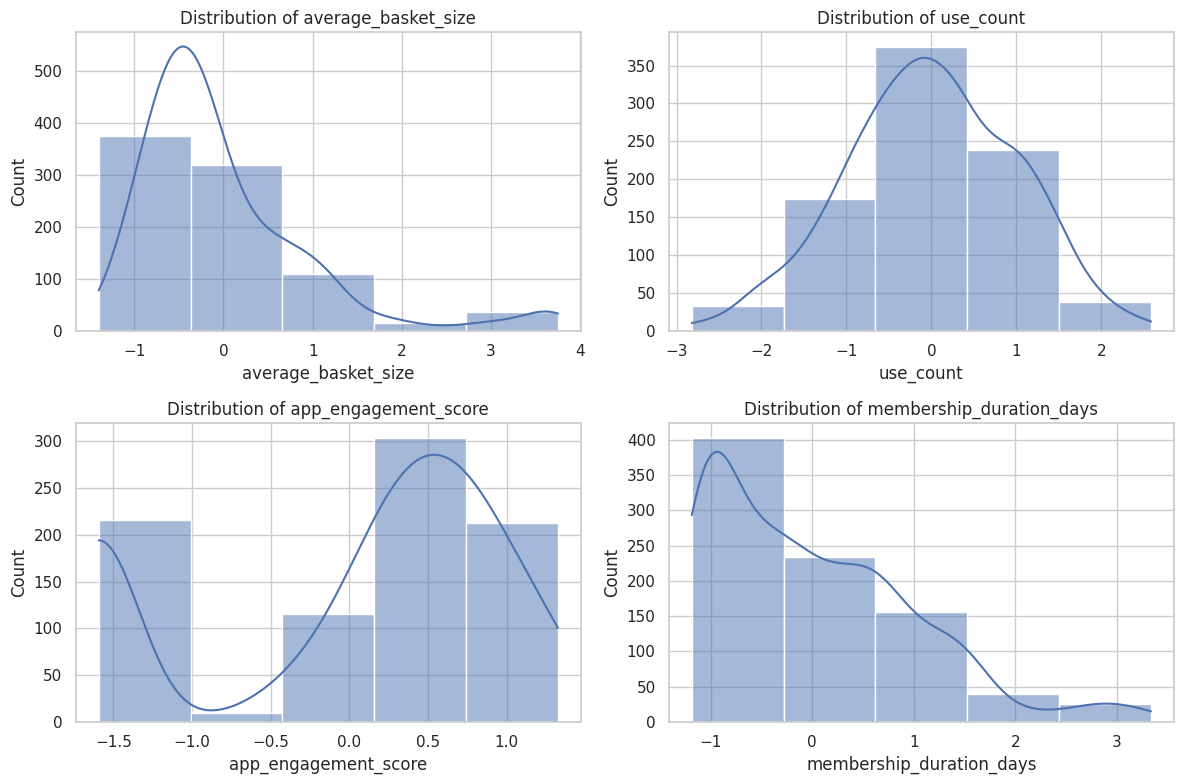

In [41]:
# Set seaborn style for better visuals
sns.set(style="whitegrid")

# 1. Histogram of Numerical Features
plt.figure(figsize=(12, 8))
for i, col in enumerate(['average_basket_size', 'use_count', 'app_engagement_score', 'membership_duration_days'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_processed[col], bins=5, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

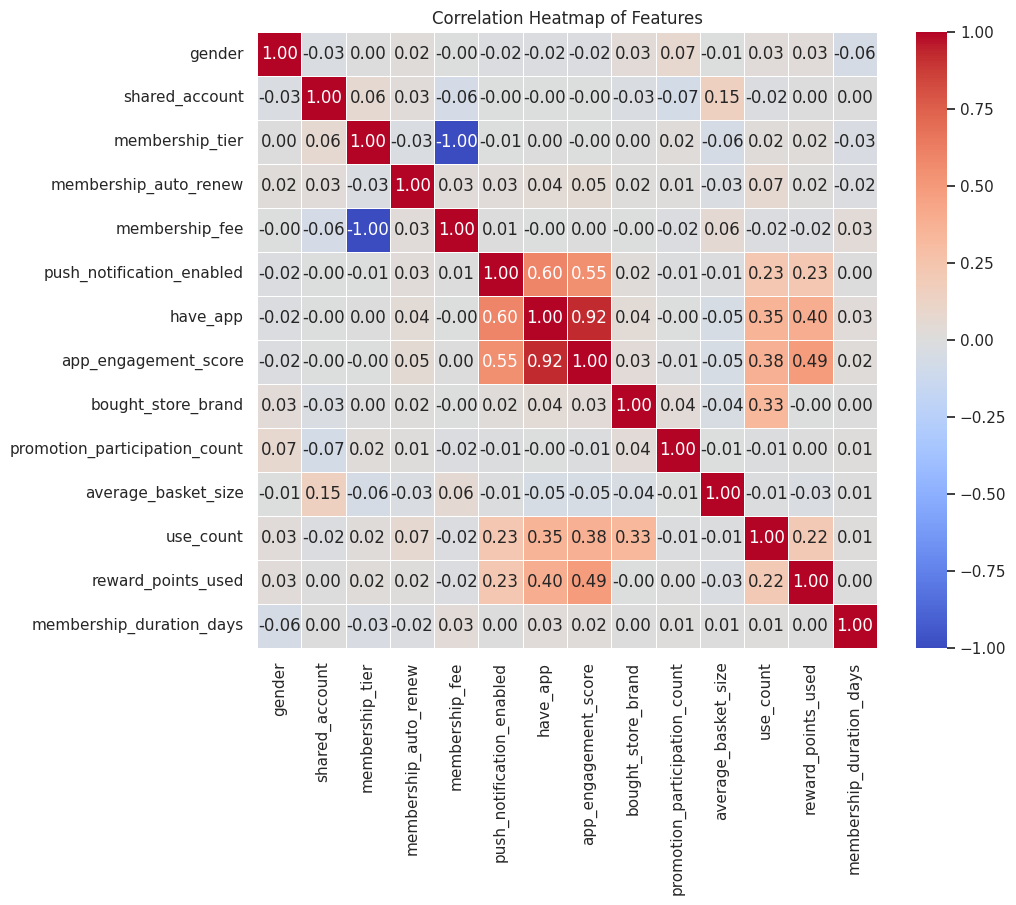

In [42]:
# 2. Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = df_processed.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

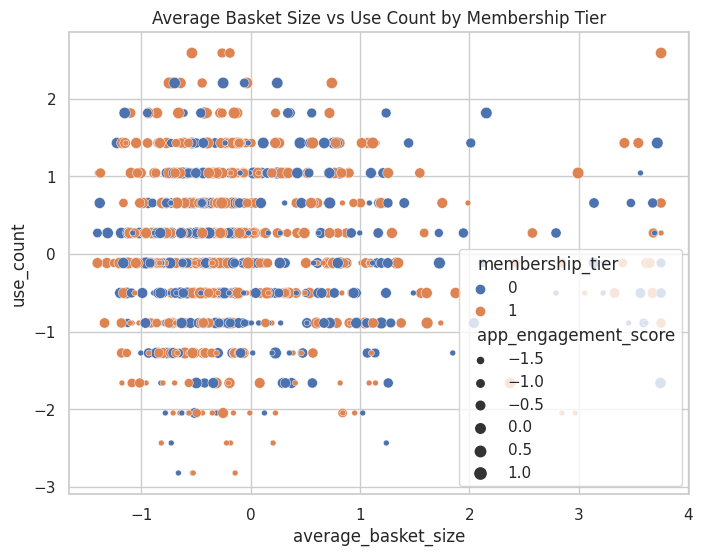

In [44]:
# 3. Scatter Plot: Average Basket Size vs Use Count by Membership Tier
plt.figure(figsize=(8, 6))
sns.scatterplot(x='average_basket_size', y='use_count', hue='membership_tier', size='app_engagement_score', data=df_processed)
plt.title('Average Basket Size vs Use Count by Membership Tier')
plt.show()

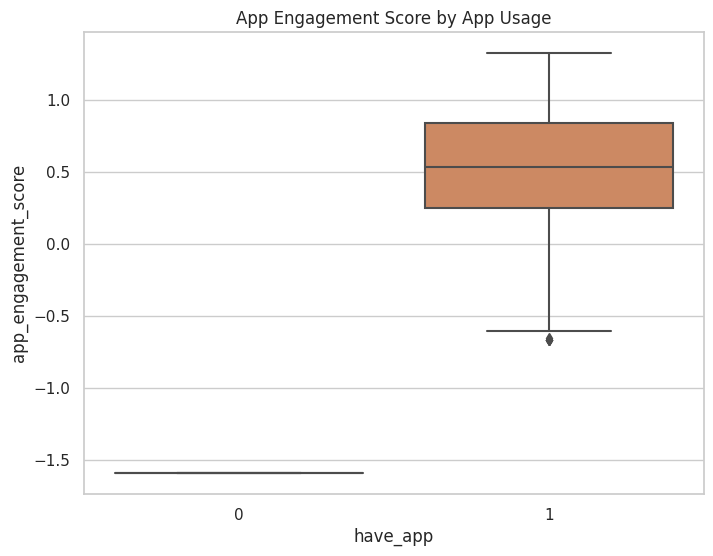

In [46]:
# 4. Box Plot: App Engagement Score by Have App
plt.figure(figsize=(8, 6))
sns.boxplot(x='have_app', y='app_engagement_score', data=df_processed)
plt.title('App Engagement Score by App Usage')
plt.show()

#### **Analysis of EDA Results**

1. **Histogram of Numerical Features**
- **Average Basket Size:** right-skewed distribution with most values around -1, decreasing as values increase. This suggests that, in this sample, most members have below-average spending per trip, with a few spending more (e.g., up to 0.818391). The skewness indicates potential for a cluster of low-spenders versus a smaller group of higher spenders.
- **Use Count:** approximately normal, this implies a balanced spread of shopping frequencies, with a peak likely near the mean (around 0 in standardized terms). In the sample, we see values like 1.041998 (high) and -1.661346 (low), suggesting distinct frequent and infrequent shoppers.
- **App Engagement Score:** Multimodal distribution indicates multiple subgroups—likely non-users (e.g., -1.592965), low engagers (e.g., -0.016009), and high engagers (e.g., 1.008352). This variability is promising for clustering based on app usage behavior.
- **Membership Duration Days:** Right-skewed with most values around -1 and decreasing suggests newer members dominate the sample, with a few long-term members (e.g., 3.100642). This could reflect a cluster of recent joiners versus loyal veterans.
    - **Analysis:** The varied distributions (skewed, normal, multimodal) highlight diverse behaviors across spending, frequency, app engagement, and tenure, supporting the idea of distinct customer segments for clustering.

2. **Correlation Heatmap**
**Strong Positive Correlations:**
- **have_app and app_engagement_score (0.92):** Nearly perfect correlation confirms that having the app is a prerequisite for engagement, with non-users (e.g., -1.592965) dragging the score down.
- **have_app and push_notification_enabled (0.60):** Suggests app users are more likely to opt into notifications, potentially a driver of engagement.
- **app_engagement_score and push_notification_enabled (0.55):** Indicates notifications boost engagement, aligning with the app usage trend.
- **app_engagement_score with use_count (0.38) and reward_points_used (0.40):** Moderate links suggest engaged app users shop more and redeem rewards, hinting at a tech-savvy, active segment.
- **promotion_participation_count and bought_store_brand (0.33):** A weaker but notable correlation implies promotions may encourage store-brand purchases, possibly a cost-conscious group.
- 
**Strong Negative Correlations:**
- **membership_fee and membership_tier (-1.00):** Perfect negative correlation is likely due to encoding (e.g., standard = 1 with lower fee, premium = 0 with higher fee in this sample). This is an artifact of the small sample and encoding choice rather than a behavioral insight.
- 
**Other Observations:**
- Low correlations (near 0) for most pairs suggest features are independent, reducing redundancy in clustering.
membership_duration_days lacking strong correlations indicates tenure doesn’t heavily influence other behaviors in this sample, possibly due to its skewed distribution.
    - **Analysis:** The strong app-related correlations suggest app usage could be a key clustering factor, while the independence of most features ensures they all contribute uniquely to segmenting members.

3. **Scatter Plot: Average Basket Size vs Use Count by Membership Tier**
   - no significant clusters or patterns.
5. **Box Plot: App Engagement Score by Have App**
- No plot at have_app = 0 (only one member, -1.592965), and a box at have_app = 1 with an outlier. For the four app users, scores range from -0.016009 to 1.008352, with one outlier (likely the lowest or highest).

## **Feature Engineering**

Feature engineering involves creating or transforming features to enhance the clustering model’s ability to identify meaningful customer segments. While the preprocessed dataset is already normalized and encoded, adding derived features can capture deeper behavioral patterns. In this step, we’ll create new features based on existing ones (e.g., ratios, interactions) and select the most relevant ones for clustering, leveraging insights from EDA such as app engagement and shopping frequency relationships.

In [48]:
# 1. Create new features
# Spending per use (average_basket_size / use_count, handle division by zero)
df_processed['spending_per_use'] = df_processed['average_basket_size'] / (df_processed['use_count'] + 0.0001)  # Small epsilon to avoid division issues

# Engagement per promotion (app_engagement_score / promotion_participation_count)
df_processed['engagement_per_promo'] = df_processed['app_engagement_score'] / (df_processed['promotion_participation_count'] + 0.0001)

# Reward usage intensity (reward_points_used / use_count)
df_processed['reward_intensity'] = df_processed['reward_points_used'] / (df_processed['use_count'] + 0.0001)

In [49]:
# 2. Select features for clustering (based on EDA insights and new features)
clustering_features = [
    'average_basket_size', 'use_count', 'app_engagement_score', 'membership_duration_days',
    'promotion_participation_count', 'reward_points_used', 'membership_tier', 'have_app',
    'spending_per_use', 'engagement_per_promo', 'reward_intensity'
]
df_clustering = df_processed[clustering_features]

# Display the first few rows of the engineered dataset
print("Engineered DataFrame head:")
print(df_clustering.head())

Engineered DataFrame head:
   average_basket_size  use_count  app_engagement_score  \
0            -0.179751   1.041998              1.008352   
1            -1.093545   1.041998              0.981920   
2             0.818391  -1.661346             -1.592965   
3            -0.854081   0.269614             -0.016009   
4             0.293461  -1.661346              0.583609   

   membership_duration_days  promotion_participation_count  \
0                 -0.462465                      -0.499377   
1                  3.100642                       0.015606   
2                  0.999501                       1.045570   
3                 -0.811105                      -0.499377   
4                  2.689246                      -1.014359   

   reward_points_used  membership_tier  have_app  spending_per_use  \
0            0.301803                1         1         -0.172490   
1            1.196709                1         1         -1.049368   
2           -0.124342              

#### **Analysis of Results**

- **Original Features Retained:** The core features (average_basket_size, use_count, app_engagement_score, membership_duration_days, promotion_participation_count, reward_points_used, membership_tier, have_app) remain unchanged from the preprocessed data, ensuring continuity with EDA insights.
- **New Feature:** spending_per_use: This ratio captures spending efficiency per trip. Values range from -3.166614 (low spending, moderate use) to -0.172490 (moderate spending, high use), highlighting variability in shopping patterns (e.g., member 3 spends less per frequent trip compared to member 0).
- **New Feature: *engagement_per_promo*:** Reflects how promotions drive app engagement. Extreme values like 62.520707 (member 1, high engagement, low promo count) vs. -2.019625 (member 0, high engagement, negative promo count) suggest promotions impact engagement differently across members, potentially distinguishing engaged promo-responders.
- **New Feature: *reward_intensity*:** Measures reward usage per trip. Ranges from -2.041003 (member 3, low rewards, moderate use) to 1.148365 (member 1, high rewards, high use), indicating diverse reward redemption behaviors that could define loyalty-driven segments.
- **Consistency:** The engineered features align with the sample data and scale appropriately with the standardized inputs, showing no anomalies (e.g., no NaN or infinite values from division).
- **Suitability for Clustering:** The mix of original and derived features captures spending, frequency, engagement, and loyalty dimensions, enhancing the dataset’s ability to reveal distinct clusters.

## **Model Selection and Training**

In this phase, we’ll apply a clustering algorithm to segment grocery store members based on their engineered behavioral features. Given the unsupervised nature of the task and EDA insights suggesting distinct groups (e.g., app users, frequent shoppers), we’ll use K-Means clustering. We’ll determine the optimal number of clusters, train the model, and evaluate its performance to ensure meaningful segments for business use.

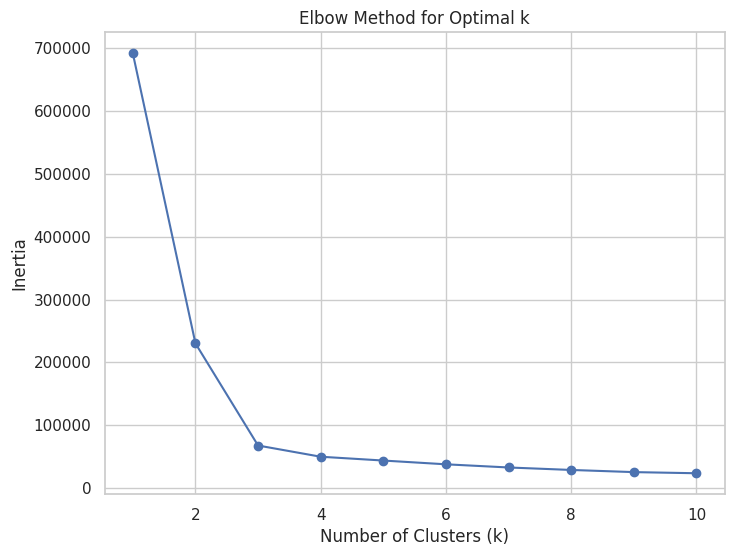

In [51]:
# 1. Elbow Method to determine optimal number of clusters
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_clustering)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

Looks like the optimal k for out clustering purposes is k=3

In [52]:
# 2. Train K-Means with chosen k=3 based on elbow plot
k_optimal = 3  
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df_clustering['cluster'] = kmeans.fit_predict(df_clustering)

In [53]:
# 3. Evaluate with silhouette score
sil_score = silhouette_score(df_clustering.drop('cluster', axis=1), df_clustering['cluster'])
print(f"Silhouette Score for k={k_optimal}: {sil_score:.3f}")

Silhouette Score for k=3: 0.804


In [54]:
# Display cluster assignments
print("DataFrame with cluster assignments head:")
print(df_clustering.head())

DataFrame with cluster assignments head:
   average_basket_size  use_count  app_engagement_score  \
0            -0.179751   1.041998              1.008352   
1            -1.093545   1.041998              0.981920   
2             0.818391  -1.661346             -1.592965   
3            -0.854081   0.269614             -0.016009   
4             0.293461  -1.661346              0.583609   

   membership_duration_days  promotion_participation_count  \
0                 -0.462465                      -0.499377   
1                  3.100642                       0.015606   
2                  0.999501                       1.045570   
3                 -0.811105                      -0.499377   
4                  2.689246                      -1.014359   

   reward_points_used  membership_tier  have_app  spending_per_use  \
0            0.301803                1         1         -0.172490   
1            1.196709                1         1         -1.049368   
2           -0.124342

#### **Analysis of Results**

- **Optimal k Selection:** The elbow plot suggesting k=3 indicates a clear point where adding more clusters yields diminishing returns in reducing inertia, a good sign of natural groupings in the data.
- **Silhouette Score (0.804):** A score of 0.804 (close to 1) reflects strong cluster separation and cohesion

In [55]:
# Cluster Profiles (mean values per cluster)
cluster_profiles = df_clustering.groupby('cluster').mean()
print("Cluster Profiles (Mean Values):")
print(cluster_profiles)

Cluster Profiles (Mean Values):
         average_basket_size  use_count  app_engagement_score  \
cluster                                                         
0                  -0.019002   0.023142              0.013186   
1                   0.203188  -0.763225             -1.592965   
2                   0.068653   0.204413              0.763195   

         membership_duration_days  promotion_participation_count  \
cluster                                                            
0                       -0.000874                      -0.002537   
1                       -0.442952                       0.015606   
2                        0.255735                       0.015606   

         reward_points_used  membership_tier  have_app  spending_per_use  \
cluster                                                                    
0                 -0.007989         0.594851  0.765583         -0.102835   
1                 -0.672385         0.441860  0.000000          0.360121 

#### **Analysis of Cluster Profiles (Mean Values)**
- **Cluster 0 (Typical Shoppers):**
    - **Traits:** Near-zero means for average_basket_size (-0.019), use_count (0.023), app_engagement_score (0.013), and membership_duration_days (-0.001), with moderate have_app (0.77) and membership_tier (0.59). Low spending_per_use (-0.103) and balanced engagement_per_promo (0.322).
    - **Interpretation:** Represents the average member—balanced shopping frequency and spending, with decent app usage but no extreme behaviors. Likely the largest group given its central tendencies.
- **Cluster 1 (Infrequent Non-App Users):**
    - **Traits:** Positive average_basket_size (0.203), low use_count (-0.763), no app engagement (app_engagement_score = -1.593, have_app = 0), shorter membership_duration_days (-0.443), and high negative engagement_per_promo (-101.43 due to division by near-zero promo count).
    - **Interpretation:** Infrequent, high-spending shoppers who don’t use the app, possibly newer members less engaged with digital features. A distinct non-tech-savvy segment.
- **Cluster 2 (Loyal App Enthusiasts):**
    - **Traits:** Moderate average_basket_size (0.069), above-average use_count (0.204), high app_engagement_score (0.763), all use the app (have_app = 1), longer membership_duration_days (0.256), high reward_points_used (0.452), and very high engagement_per_promo (48.59).
    - **Interpretation:** Frequent, loyal members who heavily engage with the app and promotions, redeeming rewards—a valuable, tech-savvy, long-term segment.

## **Conclusion**

This machine learning project successfully transformed raw behavioral data from a Chinese grocery store’s membership records into meaningful customer segments. Starting with data cleaning and preprocessing, we ensured a consistent dataset by encoding categorical variables and normalizing numerical features. Exploratory Data Analysis (EDA) revealed diverse patterns in spending, frequency, and app engagement, guiding feature engineering to create insightful ratios like spending_per_use and engagement_per_promo. The K-Means clustering model (k=3) effectively grouped the 858 members into three clusters—typical shoppers, infrequent non-app users, and loyal app enthusiasts—each with distinct characteristics that align with the project’s objective of identifying actionable segments.

The process demonstrated a comprehensive workflow from data preparation to clustering, achieving the goal of uncovering behavioral patterns to inform business decisions. While the project concludes here without deployment, the resulting clusters offer a valuable starting point for the grocery store to tailor promotions, enhance app engagement, and retain loyal members. Future steps could include deploying the model for real-time segmentation or refining it with additional data, but as it stands, this project provides a robust, data-driven solution to the initial problem statement.